# Extracting data from President Dataset  

We have found president data set at the source https://dataverse.harvard.edu/file.xhtml?fileId=10244938&version=8.0.  

It contains results of presidental elections (number of votes per each candidate) per state from 1976 to 2020.  

Columns dataset contains are:

* `year` - year in which elections are held
* `office` - U.S. PRESIDENT
* `state` - state name
* `state_po` - U.S. postal code state abbreviation
* `state_fips` - state FIPS code
* `state_cen` - U.S. Census state code
* `state_ic` - ICPSR state code
* `candidate` - name of the candidate
* `party_detailed` - party of the candidate
* `party_simplified` - party of the candidate (one of DEMOCRAT, REPUBLICAN, LIBERTARIAN, OTHER)
* `writein` - vote totals associated with write-in candidates (TRUE - write-in candidates, FALSE - non-write-in candidates)
* `candidatevotes` - votes received by this candidate for this particular party
* `totalvotes` - total number of votes cast for this election

In [43]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
file_path = pathlib.Path("data") / "1976-2020-president.csv"
president_data = pd.read_csv(file_path)

In [3]:
president_data.head(5)

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


Our beer reviews dataset contains data from 2001 to 2017. Therefore, we need to filter out the election data to span the same years.  

Also, we are going to drop the columns that are irrelevant for our analysis. We are keeping: year, state, party simplified, candidate votes and total votes. Only possible entries for party simplified are: REPUBLICAN, DEMOCRAT, LIBERTARIAN, OTHER. Since can be multiple candidates in each state that fall under the umbrella of OTHER, we will some votes corresponding to OTHER per each state.

In [16]:
pr_df = president_data.copy()

# Filter out years
pr_df_filt = pr_df[(pr_df['year'] >= 2001) & (pr_df['year'] <= 2017)]

# Filter out irrelevant columns
relevant_columns = ['year', 'state', 'party_simplified', 'candidatevotes', 'totalvotes']
pr_df_filt = pr_df_filt[relevant_columns]

pr_df_filt['party_simplified'].value_counts()

# Collect all OTHER candidates per each state - sum their votes
pr_df_filt_other = pr_df_filt[pr_df_filt['party_simplified'] == 'OTHER'].groupby(['state', 'year']).agg({'candidatevotes' : 'sum', 'totalvotes' : 'first'}).reset_index()
pr_df_filt_other['party_simplified'] = 'OTHER'

pr_df_non_other = pr_df_filt[pr_df_filt['party_simplified'] != 'OTHER']
pr_df_combined = pd.concat([pr_df_non_other, pr_df_filt_other])

In [17]:
pr_df_combined.head(5)

,year,state,party_simplified,candidatevotes,totalvotes
2411,2004,ALABAMA,REPUBLICAN,1176394,1883415
2412,2004,ALABAMA,DEMOCRAT,693933,1883415
2415,2004,ALASKA,REPUBLICAN,190889,312598
2416,2004,ALASKA,DEMOCRAT,111025,312598
2419,2004,ALASKA,LIBERTARIAN,1675,312598


Now, we want to establish new columns: one for each party_simplified which will contain percentage of votes each party got.

In [24]:
pr_df_combined['percentage'] = (pr_df_combined['candidatevotes'] / pr_df_combined['totalvotes']) * 100
pr_df_percentage = pr_df_combined.drop(['candidatevotes', 'totalvotes'], axis=1, inplace=False)
pr_df_percentage.head(5)

,year,state,party_simplified,percentage
2411,2004,ALABAMA,REPUBLICAN,62.460690
2412,2004,ALABAMA,DEMOCRAT,36.844402
2415,2004,ALASKA,REPUBLICAN,61.065330
2416,2004,ALASKA,DEMOCRAT,35.516862
2419,2004,ALASKA,LIBERTARIAN,0.535832


## Statistics over year, parties etc.

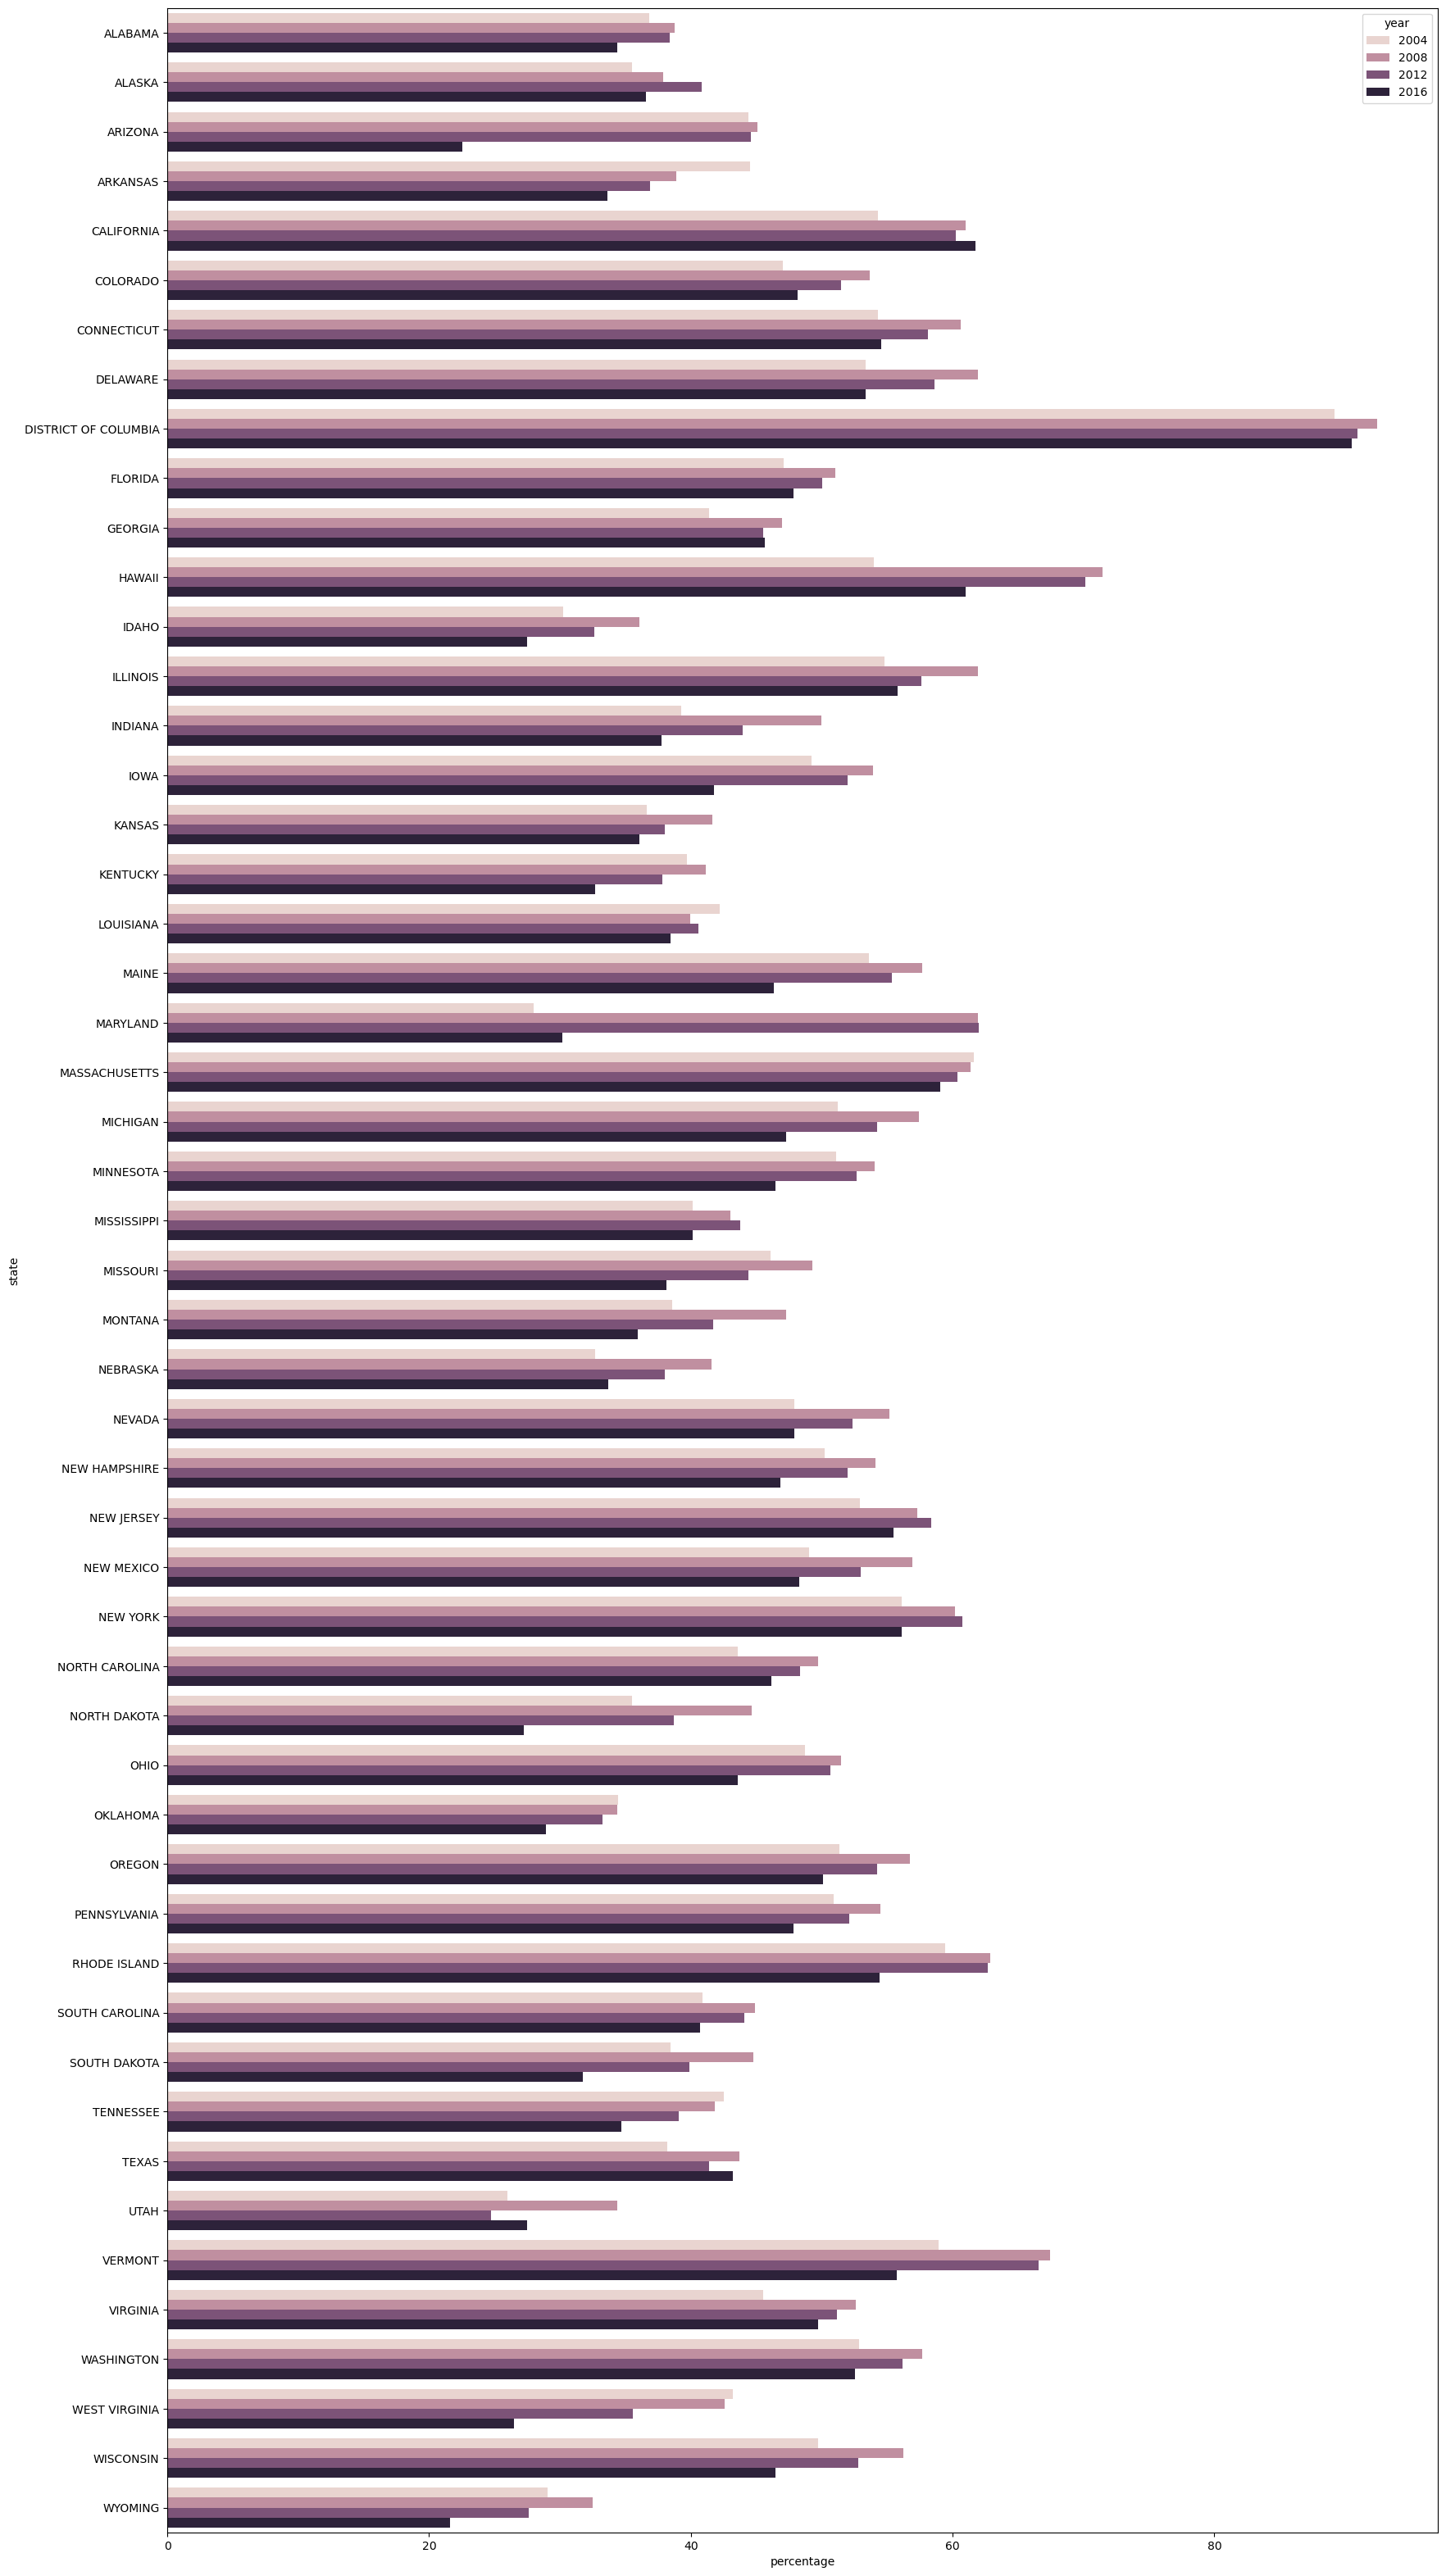

In [45]:
pr_df_democrats = pr_df_percentage[pr_df_percentage['party_simplified'] == 'DEMOCRAT']
pr_df_republican = pr_df_percentage[pr_df_percentage['party_simplified'] == 'REPUBLICAN']

plt.figure(figsize=(20,40))
bar1 = sns.barplot(pr_df_democrats, x='percentage', y='state', hue='year', errorbar=None)

<Axes: xlabel='percentage', ylabel='state'>

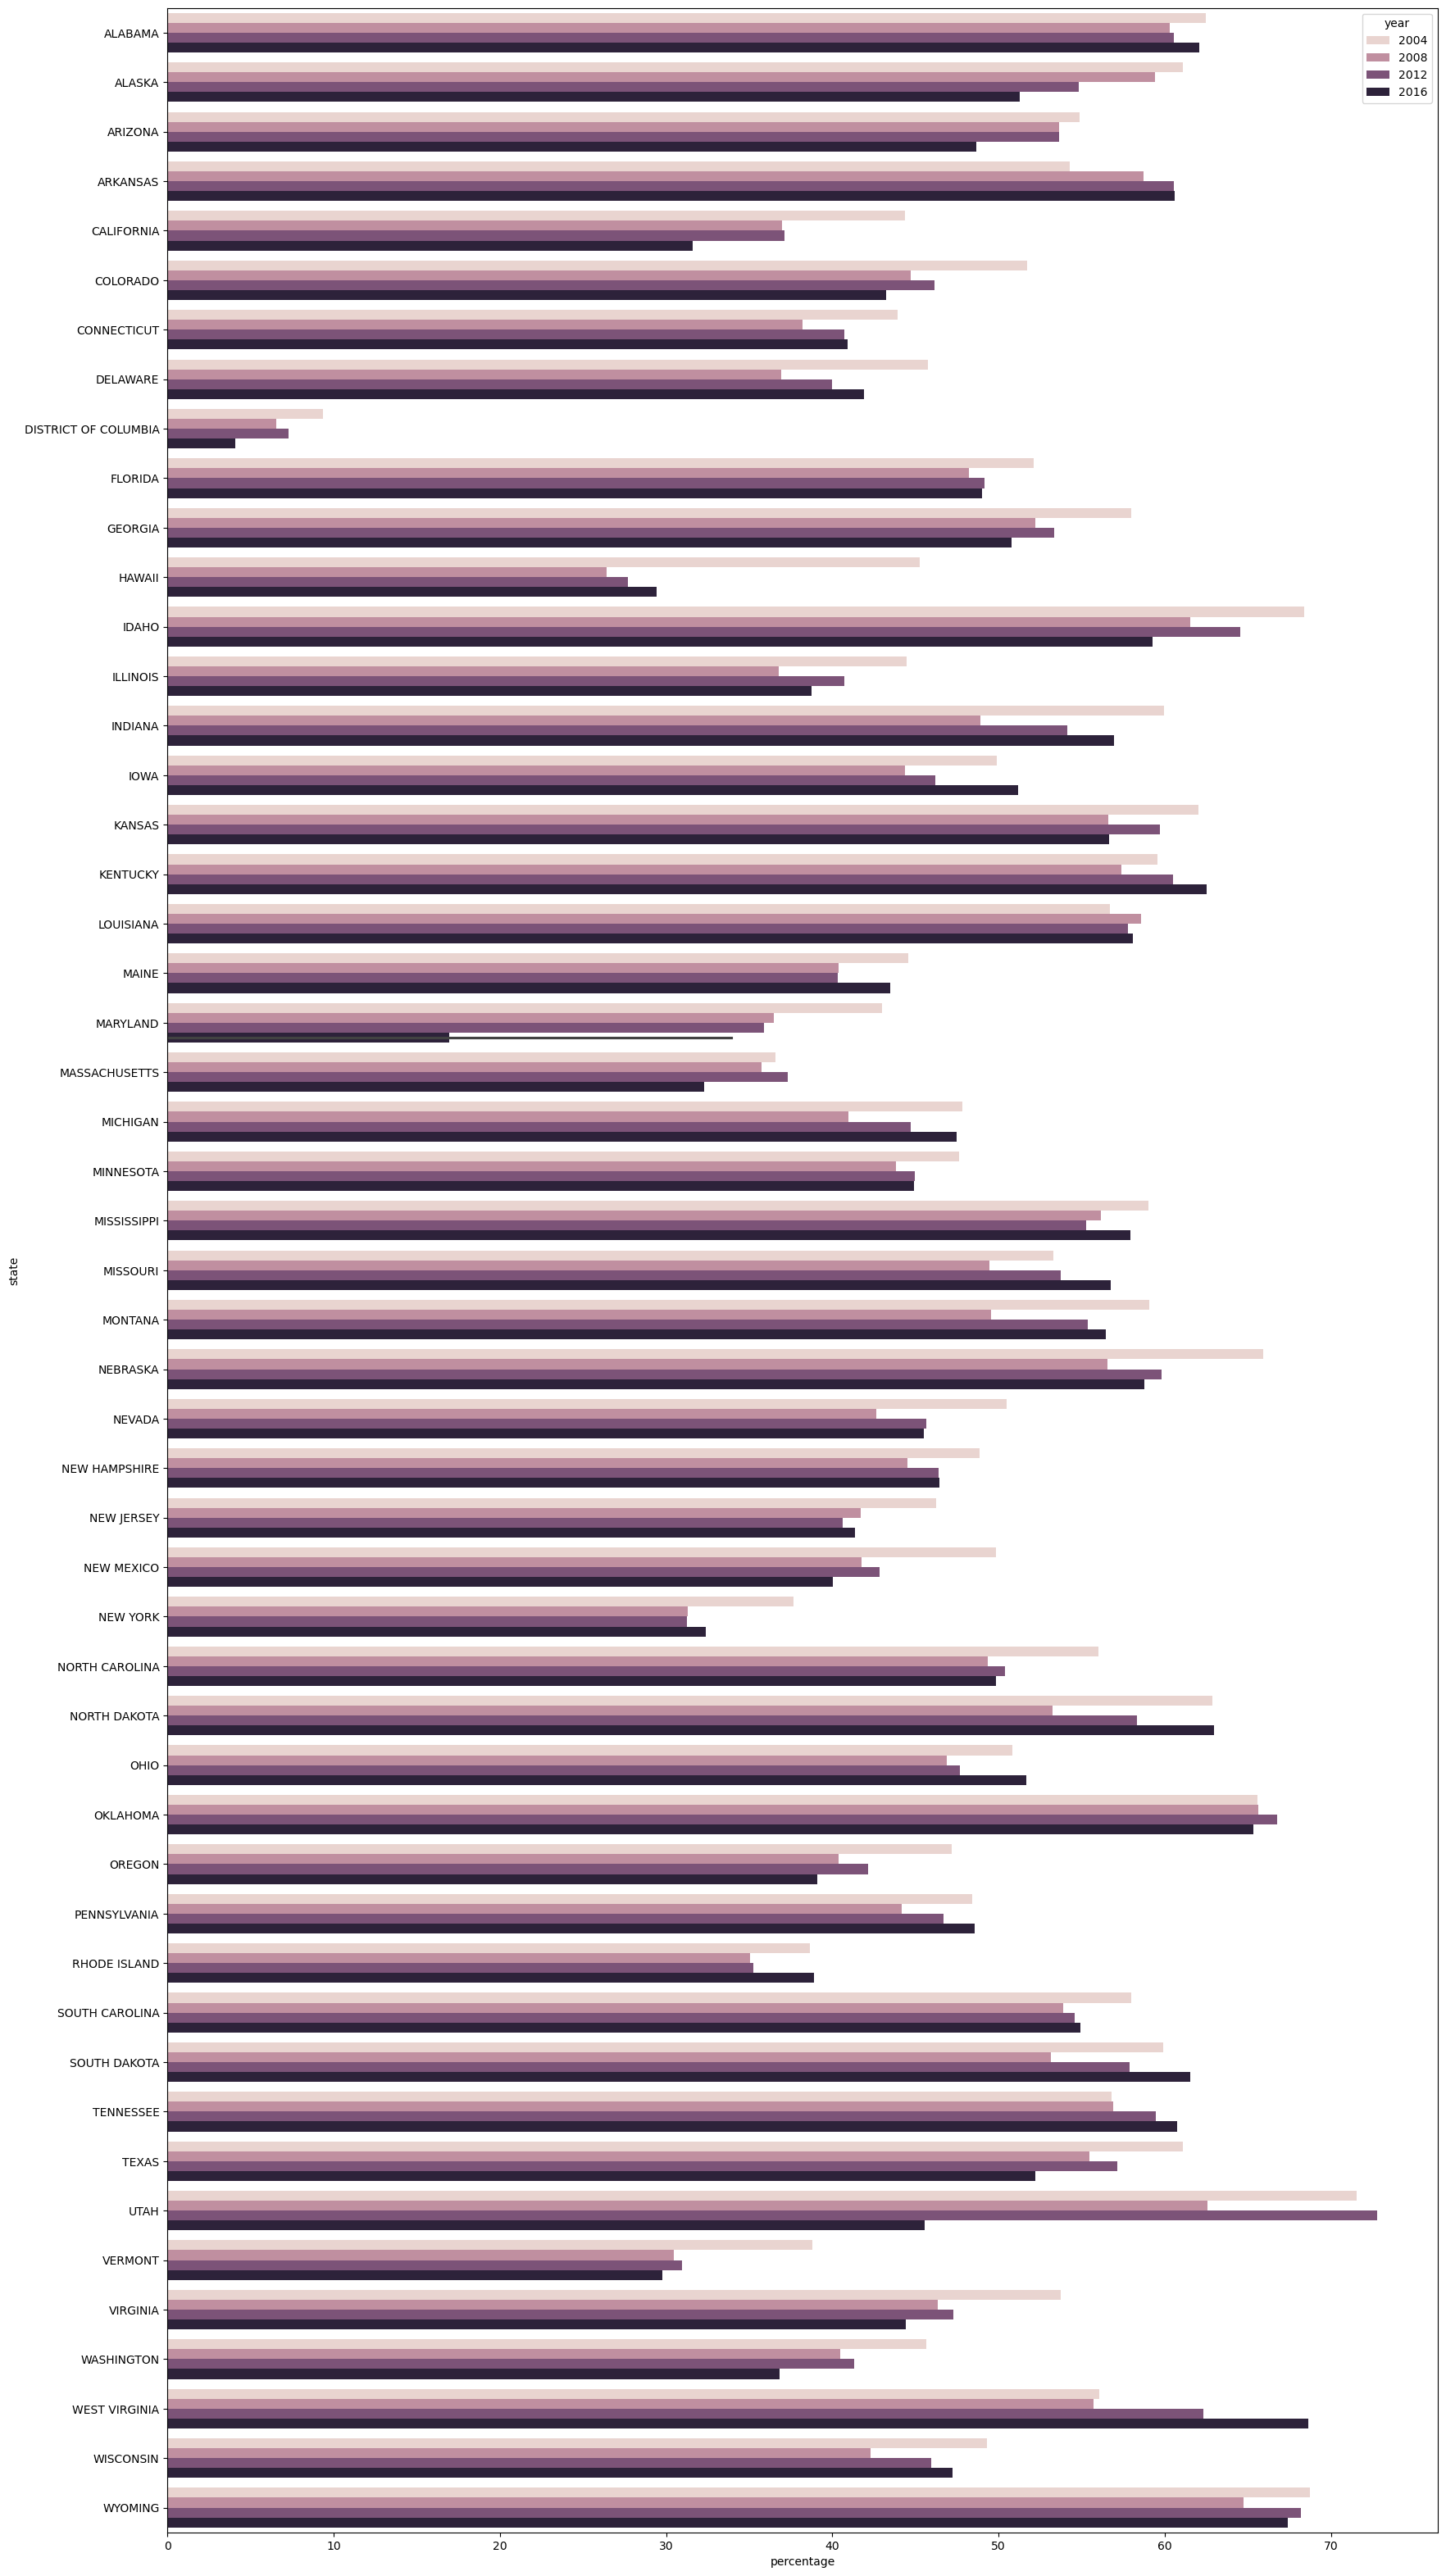

In [46]:
plt.figure(figsize=(20, 40))
sns.barplot(pr_df_republican, x='percentage', y='state', hue='year')